<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S8_ResNet18_Single_File_Readable_Displays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

In [0]:
class DataLoader:
      
    def __init__(self, shuffle, batch_size, seed):
        self.shuffle = shuffle,
        self.batch_size = batch_size,
        self.seed    = seed
         
        cuda = torch.cuda.is_available()
            
        if cuda:
           torch.cuda.manual_seed(seed) # Seed is for reproducibility
      
        # # dataloader arguments # # which we load
        self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=shuffle, batch_size=int(batch_size/2))

    def load(self, data):
        return torch.utils.data.DataLoader(data, **self.dataloader_args)

In [0]:
class Transforms_custom:
      def __init__(self,normalize=False, mean=None, stdev=None):
      
          self.normalize = normalize
          self.mean      = mean      ## Make sure you pass the meand and stdev whenever normalization is set to true 
          self.stdev     = stdev
      
      
      # Define a method for test data set as it does not need extra transformations.
      # We just need to normalize with mean and stdev
      
      def test_transforms(self):
          transforms_list = [transforms.ToTensor()]
          if (self.normalize):
             transforms_list.append(transforms.Normalize(self.mean,self.stdev))
          return transforms.Compose(transforms_list)
          
      # Define a method for train data . It can have multiple transformations other than changing to tensor and normalizing
      # so create your lists accordingly . One for before converting to tensor and normalization 
      # one for after converting it to tensor and normalization
      
      
      def train_transforms(self , before_norm=None, after_norm=None):
          if before_norm:
             transforms_list = before_norm 
             transforms_list.append(transforms.ToTensor())
          else:
             transforms_list = [transforms.ToTensor()]
             
          if (self.normalize):
             transforms_list.append(transforms.Normalize(self.mean,self.stdev))
           
          if after_norm:
             transforms_list.extend(after_norm)
           
          return transforms.Compose(transforms_list)

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #print('Inside BasicBlock Class Making conv1 :in_planes, planes, stride : ', in_planes, planes, stride)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #print('self.conv1:',self.conv1)
        #print('Inside BasicBlock Class Making BN1 :planes : ', planes)
        self.bn1 = nn.BatchNorm2d(planes)
        #print('self.bn1:',self.bn1)
        #print('Inside BasicBlock Class Making conv2 :planes : ', planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        #print('self.conv1:',self.conv1)        
        #print('Inside BasicBlock Class Making BN2 :planes : ', planes)        
        self.bn2 = nn.BatchNorm2d(planes)
        #print('self.bn1:',self.bn1)        

        #print('Inside BasicBlock Class Making Shortcut')        
        self.shortcut = nn.Sequential()
        #print('Inside BasicBlock Class self.shortcut : ', self.shortcut)        
        if stride != 1 or in_planes != self.expansion*planes:
            #print('Basic Block, Inside IF block to create SHORTCUT -stride, in_planes, planes, self.expansion:',stride,in_planes,planes,self.expansion)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
            #print('Basic Block, After self.shortcut creation:',self.shortcut)

    def forward(self, x):
        #print('Basic Block Input step: x', x.shape, '/n')
        out = F.relu(self.bn1(self.conv1(x)))
        #print('Basic Block after F.relu(self.bn1(self.conv1(x))):', out.shape, '/n')                
        out = self.bn2(self.conv2(out))
        #print('Basic Block after self.bn2(self.conv2(out)):', out.shape, '/n')        
        out += self.shortcut(x)
        #print('Basic Block after self.shortcut(x):',out.shape,'/n' )
        out = F.relu(out)
        #print('Basic Block after F.relu(out):',out.shape,'/n' )        
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        print('Inside ResNet Class Making conv1')
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        print('Resnet self.conv1:',self.conv1)
        print('Inside ResNet Class Making Batchnorm1')
        self.bn1 = nn.BatchNorm2d(64)
        #print('Resnet self.bn1:',self.bn1)
        print('Inside ResNet Class Making Layer 1')        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        print('Resnet self.layer1:',self.layer1)
        print('Inside ResNet Class Making Layer 2')
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        print('Resnet self.layer2:',self.layer2)        
        print('Inside ResNet Class Making Layer 3')        
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        print('Resnet self.layer3:',self.layer3)          
        print('Inside ResNet Class Making Layer 4')        
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        print('Resnet self.layer4:',self.layer4)          
        print('Inside ResNet Class Making GAP')          
        self.Gap1   = nn.AdaptiveAvgPool2d(output_size=(1,1))
        print('Resnet self.Gap1:',self.Gap1)          
        print('Inside ResNet Class Making FC Layer')          
        self.fc     = nn.Conv2d(512*block.expansion, num_classes, kernel_size=1, stride = 1, padding=0, bias=False)
        print('Resnet self.fc:',self.fc)          
         
    def _make_layer(self, block, planes, num_blocks, stride):
        #print('_make_Layer starts -> Block, Planes, num_blocks, stride : ',block, planes, num_blocks, stride)
        strides = [stride] + [1]*(num_blocks-1)
        #print('Inside Make Layers : _make_layer_ calculation, strides : ', strides)
        layers = []
        i = 0 
        for stride in strides:
            #print('Resnet For Loop iteration:',  i)
            #print('Inside Make Layers before calling BLOCK : layers:',layers)
            layers.append(block(self.in_planes, planes, stride))
            #print('Inside Make Layers : stride, self.in_planes, planes, block.expansion: ',stride, self.in_planes, planes, block.expansion)
            #print('Inside Make Layers After calling BLOCK: layers:',layers)
            self.in_planes = planes * block.expansion
            #print('Inside Make Layers self.in_planes :',self.in_planes)
            #print('Inside Make Layers nn.Sequential(*layers):',nn.Sequential(*layers))
            i += 1
        return nn.Sequential(*layers)

    def forward(self, x):
        #print('I/P Shape:',x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        #print('After Initial Conv:',out.shape)
        out = self.layer1(out)
        #print('After Layer1:',out.shape)
        out = self.layer2(out)
        #print('After Layer2:',out.shape)
        out = self.layer3(out)
        #print('After Layer3:',out.shape)
        out = self.layer4(out)
        #print('After Layer4:',out.shape)
        out = self.Gap1(out)
        #print('After GAP:',out.shape)
        out = self.fc(out)
        #print('After FC:',out.shape)
        out = out.view(out.size(0), -1)
        #print('After View reshape:',out.shape)
        return F.log_softmax(out, dim=-1)
            
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [0]:
class Train_loss:
        
      def train_loss_calc(self,model, device, train_loader, optimizer, epoch, factor):
            
          self.model        = model
          self.device       = device
          self.train_loader = train_loader
          self.optimizer    = optimizer
          self.epoch        = epoch
          self.factor       = factor
          
          model.train()
          pbar = tqdm(train_loader)  # Wrapping train_loader in tqdm to show progress bar for each epoch while training
          
          correct             = 0
          total               = 0
          train_losses        = []
          train_acc           = []
          
          for batch_idx, data in enumerate(pbar,0):
                        
              images, labels = data        
                       
              images, labels = images.to(device), labels.to(device)   # Moving images and correspondig labels to GPU
              optimizer.zero_grad()  # Zeroing out gradients at start of each batch so that backpropagation won't take accumulated value
              labels_pred = model(images)  # Calling CNN model to predict the images
              loss = F.nll_loss(labels_pred, labels)   # Calculating Negative Likelihood Loss by comparing prediction vs ground truth
              
              # Applying L1 regularization to the training loss calculated
              L1_criterion = nn.L1Loss(size_average = None, reduce = None, reduction = 'mean')
              reg_loss     = 0
              for param in model.parameters():
                zero_tensor = torch.rand_like(param) * 0 # Creating a zero tensor with same size as param
                reg_loss    += L1_criterion(param, zero_tensor)
              loss += factor * reg_loss 
              
            
              # Backpropagation
              loss.backward()
              optimizer.step()
              
              # Calculating accuracies
              labels_pred_max = labels_pred.argmax(dim = 1, keepdim = True) # Getting the index of max log probablity predicted by model
              correct         += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item() # Getting count of correctly predicted
              total           += len(images) # Getting count of processed images
              train_acc_batch = (correct/total)*100
              pbar.set_description(desc=f'Train Loss = {loss.item()} Batch Id = {batch_idx} Train Accuracy = {train_acc_batch:0.2f}')

              if batch_idx == 2:
                print('2 batches covered, coming out of loop')
                break
          
          train_acc.append(train_acc_batch)  # To capture only final batch accuracy of an epoch
          train_losses.append(loss)          # To capture only final batch loss of an epoch
        
          return train_losses, train_acc         


In [0]:
class Test_loss:

       def test_loss_calc(self,model, device, test_loader):
           self.model        = model
           self.device       = device
           self.test_loader  = test_loader  
       
           model.eval()
           
           correct        = 0 
           total          = 0              
           test_loss      = 0
           test_accuracy  = 0 
           test_losses    = []
           test_acc       = []
           
           with torch.no_grad():               # For test data, we won't do backprop, hence no need to capture gradients
                for images,labels in test_loader:
 
                    images,labels    = images.to(device),labels.to(device)
                    labels_pred      = model(images)
                    test_loss        += F.nll_loss(labels_pred, labels, reduction = 'sum').item()                        
                    labels_pred_max  = labels_pred.argmax(dim =1, keepdim = True)
                    correct          += labels_pred_max.eq(labels.view_as(labels_pred_max)).sum().item()
                    total            += labels.size(0) 
                
                test_loss   /= total  # Calculating overall test loss for the epoch
                test_losses.append(test_loss)    
                                  
                test_accuracy =  (correct/total)* 100
                test_acc.append(test_accuracy)             
               
                print('\nTest set: Average loss: {:.4f}, Test Accuracy: {:.2f}\n' .format(test_loss, test_accuracy))

           return test_losses, test_acc

In [7]:
data_loader = DataLoader(shuffle=True,batch_size=128,seed=1)

mean = (0.49139968, 0.48215841, 0.44653091)
stdev = (0.24703223, 0.24348513, 0.26158784)
transform_instance  = Transforms_custom(normalize=True, mean=mean, stdev=stdev)

before_norm_list = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
               transforms.RandomRotation((-7,7),fill=(1,))]
               
test_transforms   = transform_instance.test_transforms()
train_transforms  = transform_instance.train_transforms(before_norm = None)

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18()
model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
Inside ResNet Class Making conv1
Resnet self.conv1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Inside ResNet Class Making Batchnorm1
Inside ResNet Class Making Layer 1
Resnet self.layer1: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [0]:
train_loss = Train_loss()
test_loss  = Test_loss()

# Train and Test the model 

In [0]:
EPOCH     = 1
L2_factor = 0.0005
L1_factor = 0.001
OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_factor)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,device,train_loader=trainloader,optimizer=OPTIMIZER,epoch=EPOCH,factor=L1_factor)
    test_losses, test_acc   = test_loss.test_loss_calc(model,device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0
I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After Layer4: torch.Size([128, 512, 4, 4])
After GAP: torch.Size([128, 512, 1, 1])
After FC: torch.Size([128, 10, 1, 1])
After View reshape: torch.Size([128, 10])


Train Loss = 2.435086488723755 Batch Id = 0 Train Accuracy = 3.91:   0%|          | 1/391 [00:00<06:08,  1.06it/s]

I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After Layer4: torch.Size([128, 512, 4, 4])
After GAP: torch.Size([128, 512, 1, 1])
After FC: torch.Size([128, 10, 1, 1])
After View reshape: torch.Size([128, 10])


Train Loss = 2.296074628829956 Batch Id = 1 Train Accuracy = 9.77:   1%|          | 2/391 [00:01<05:17,  1.23it/s]

I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After Layer4: torch.Size([128, 512, 4, 4])
After GAP: torch.Size([128, 512, 1, 1])
After FC: torch.Size([128, 10, 1, 1])
After View reshape: torch.Size([128, 10])


Train Loss = 2.266824960708618 Batch Id = 2 Train Accuracy = 12.50:   1%|          | 2/391 [00:01<05:17,  1.23it/s]

2 batches covered, coming out of loop


I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After Layer4: torch.Size([128, 512, 4, 4])
After GAP: torch.Size([128, 512, 1, 1])
After FC: torch.Size([128, 10, 1, 1])
After View reshape: torch.Size([128, 10])
I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After Layer4: torch.Size([128, 512, 4, 4])
After GAP: torch.Size([128, 512, 1, 1])
After FC: torch.Size([128, 10, 1, 1])
After View reshape: torch.Size([128, 10])
I/P Shape: torch.Size([128, 3, 32, 32])
After Initial Conv: torch.Size([128, 64, 32, 32])
After Layer1: torch.Size([128, 64, 32, 32])
After Layer2: torch.Size([128, 128, 16, 16])
After Layer3: torch.Size([128, 256, 8, 8])
After La

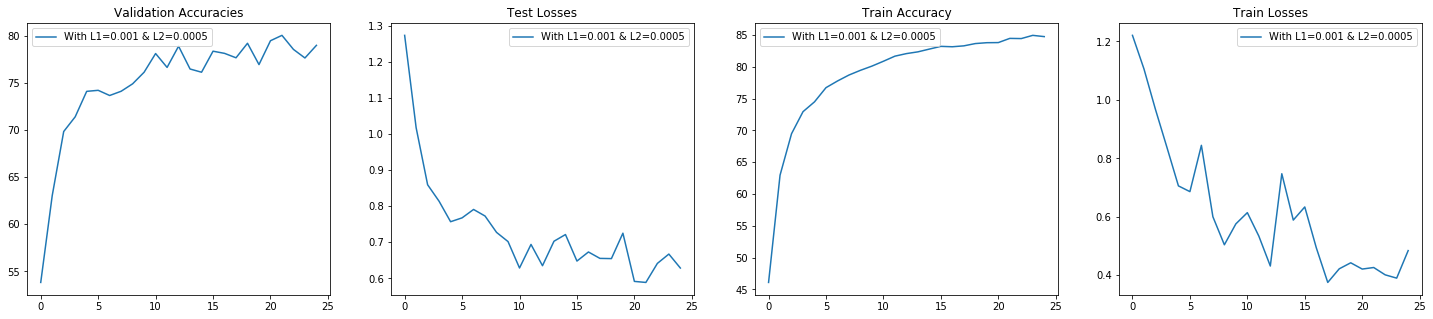

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [0]:
train_acc_all